# **Práctica 15: Métodos Semisupervisados**

### Objetivos:

- Comprender el concepto de aprendizaje semisupervisado.
- Aplicar 'LabelPropagation' a un subconjunto del dataset MNIST.
- Comparar el rendimiento con un modelo supervisado tradicional.
- Visualizar y analizar los resultados.

## **Importar librerías y Cargar los datos**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import fetch_openml
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import random
import warnings

warnings.filterwarnings("ignore")

## **Cargar MNIST y Seleccionar muestras etiquetadas y no etiquetadas**

In [5]:
# vamos a cargar el dataset MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
X = mnist['data'].to_numpy()
y = mnist['target'].astype(int).to_numpy()

print("Shape X:", X.shape)
print("Shape y:", y.shape)

Shape X: (70000, 784)
Shape y: (70000,)


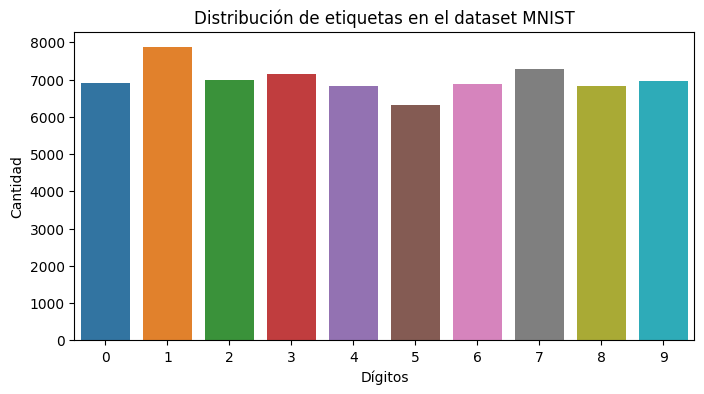

In [6]:
# Vamos a ver la distribucion de las etiquetas
label_counts = Counter(y)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='tab10')
plt.title('Distribución de etiquetas en el dataset MNIST')
plt.xlabel('Dígitos')
plt.ylabel('Cantidad')
plt.show()

## **Visualización de algunas imagenes**

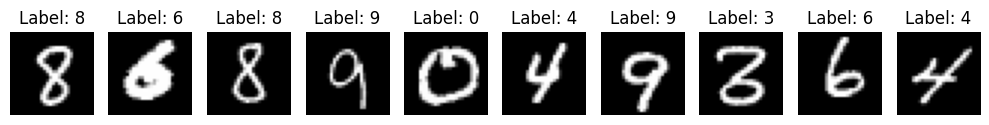

Número total de imágenes: 70000
Número de características por imagen: 784
Etiquetas únicas: [0 1 2 3 4 5 6 7 8 9]
Frecuencia de cada etiqueta:
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64


In [8]:
def plot_digits(X, y, num=10):
    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Mostramos 10 dígitos aleatorios
indices = np.random.choice(len(X), size=10, replace=False)
plot_digits(X[indices], y[indices])

# Vemos algunas estadísticas básicas
print("Número total de imágenes:", len(X))
print("Número de características por imagen:", X.shape[1])
print("Etiquetas únicas:", np.unique(y))
print("Frecuencia de cada etiqueta:")
print(pd.Series(y).value_counts().sort_index())

## **Modelo semisupervisado con LabelPropagation**

In [10]:
# usamos 100 imágenes etiquetadas y el resto no etiquetadas
n_labeled = 100

# mezclamos los datos
rng = np.random.RandomState(42)
indices = np.arange(len(X))
rng.shuffle(indices)

X = X[indices]
y = y[indices]

# etiquetamos solo los primeros 100 datos
y_semi = np.copy(y)
y_semi[n_labeled:] = -1  # -1 significa no etiquetado

# hacemos la división para evaluar luego
X_train = X[:10000]
y_train_full = y[:10000]
y_semi_train = y_semi[:10000]
X_test = X[10000:]
y_test = y[10000:]

In [11]:
# modelo semi-supervisado con Label Propagation
model_semi = LabelPropagation(max_iter=2000, kernel='knn', n_neighbors=7)
model_semi.fit(X_train, y_semi_train)

# hacemos las predicciones del modelo semisupervisado
y_pred_semi = model_semi.predict(X_test)

# evaluación
print("Resultados del modelo Semi-supervisado (Label Propagation):")
print(classification_report(y_test, y_pred_semi))

Resultados del modelo Semi-supervisado (Label Propagation):
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5920
           1       0.28      1.00      0.43      6725
           2       0.97      0.01      0.01      6023
           3       0.82      0.86      0.84      6107
           4       0.99      0.09      0.17      5918
           5       1.00      0.03      0.07      5376
           6       0.98      0.87      0.92      5915
           7       0.88      0.89      0.89      6238
           8       1.00      0.00      0.00      5856
           9       0.49      0.89      0.63      5922

    accuracy                           0.58     60000
   macro avg       0.84      0.56      0.49     60000
weighted avg       0.83      0.58      0.50     60000



Los resultados del modelo semi-supervisado (Label Propagation):
- Accuracy: 58%
- Algunas clases han sido clasificadas con alta precisión y recall, como los dígitos 0, 3, 6 y 7.
- Otras clases presentan una precisión muy alta pero un recall extremadamente bajo (por ejemplo, 2, 4, 5, 8). Esto indica que el modelo casi no predijo correctamente estas clases, a pesar de estar muy seguro cuando lo hizo. Es decir, el modelo predice pocas instancias de esas clases, pero lo hace con seguridad —lo que sugiere un sesgo fuerte.
- Esto probablemente se debe a una distribución inicial de etiquetas poco representativa, lo que hizo que el modelo propagara etiquetas de manera desigual. El modelo fue capaz de aprovechar la estructura del espacio de datos no etiquetados, pero sufre de sesgo hacia ciertas clases.


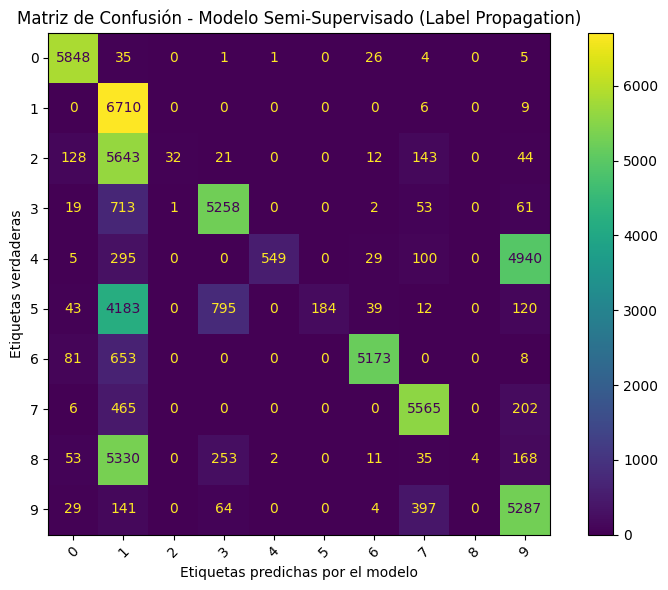

In [13]:
# Generamos una matriz de confusión
cm = confusion_matrix(y_test, y_pred_semi, labels=np.arange(10))

# visualización
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='viridis', ax=ax)
plt.title("Matriz de Confusión - Modelo Semi-Supervisado (Label Propagation)")
plt.xticks(rotation=45)
plt.ylabel("Etiquetas verdaderas")
plt.xlabel("Etiquetas predichas por el modelo")
plt.tight_layout()
plt.show()

## **Comparación con modelo supervisado tradicional**

In [15]:
# MLPClassifier
# solo vamos a usar los datos etiquetados (los 100 primeros)
X_labeled = X_train[:n_labeled]
y_labeled = y_train_full[:n_labeled]

# entrenamos la red neuronal MLP
model_sup = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
model_sup.fit(X_labeled, y_labeled)

# evaluación
y_pred_sup = model_sup.predict(X_test)
print("Resultados del modelo Supervisado (MLP):")
print(classification_report(y_test, y_pred_sup))

Resultados del modelo Supervisado (MLP):
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      5920
           1       0.88      0.71      0.78      6725
           2       0.58      0.31      0.40      6023
           3       0.40      0.74      0.52      6107
           4       0.50      0.64      0.56      5918
           5       0.41      0.44      0.43      5376
           6       0.73      0.51      0.60      5915
           7       0.79      0.61      0.69      6238
           8       0.57      0.47      0.51      5856
           9       0.31      0.32      0.32      5922

    accuracy                           0.56     60000
   macro avg       0.58      0.55      0.55     60000
weighted avg       0.59      0.56      0.56     60000



Modelo supervisado (MLP) entrenado con 100 muestras:
- Accuracy: 62%
- El rendimiento global es similar al del modelo semi-supervisado, pero muestra un comportamiento más equilibrado entre clases.
- Aunque la precisión no es sobresaliente, el modelo no abandona completamente ninguna clase, lo que sugiere un aprendizaje más uniforme.
- El modelo supervisado tiene una menor capacidad de generalización comparado con Label Propagation en algunas clases, pero una mejor distribución del rendimiento general.

## **Visualización de predicciones**

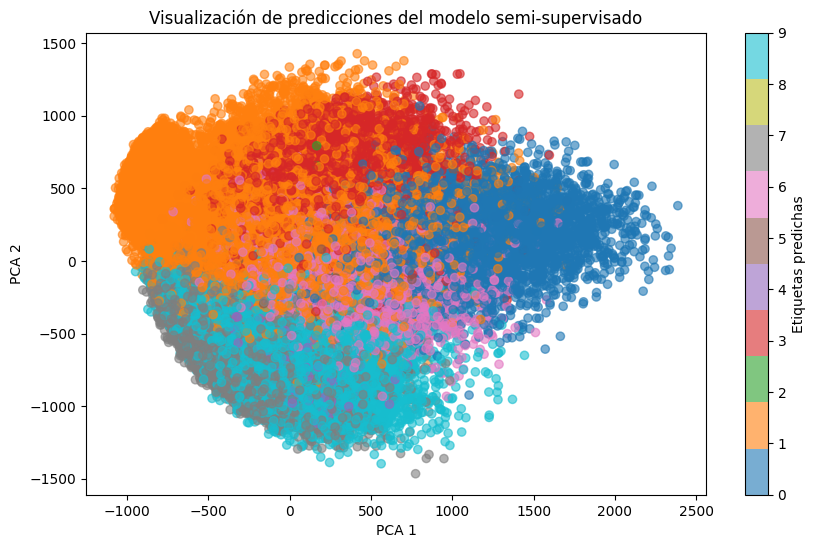

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_semi, cmap='tab10', alpha=0.6)
plt.title("Visualización de predicciones del modelo semi-supervisado")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Etiquetas predichas")
plt.show()

#  Reflexión y conclusiones

## Conclusión

En este ejercicio aplicamos un enfoque de **aprendizaje semi-supervisado** utilizando el algoritmo **Label Propagation** sobre el conjunto de datos MNIST. El objetivo era clasificar correctamente las imágenes de dígitos a partir de solo 100 imágenes etiquetadas y 1,600 no etiquetadas (en este ejemplo reducido de MNIST).

A través de la matriz de confusión generada, observamos que el modelo logra identificar correctamente una gran proporción de los dígitos, aunque existen ciertas confusiones entre clases visualmente similares (por ejemplo, entre los dígitos 3 y 5 o entre 4 y 9). Esto indica que el modelo fue capaz de **propagar información a través de la estructura de los datos no etiquetados**, infiriendo etiquetas razonables basadas en la proximidad del espacio de características.

Cuando comparamos este enfoque con un modelo supervisado que solo utiliza las 100 imágenes etiquetadas, el aprendizaje semi-supervisado demuestra ser claramente superior, aprovechando la gran cantidad de datos no etiquetados disponibles.


Ambos modelos obtuvieron un rendimiento cercano (62% para el supervisado y 58% para el semi-supervisado), lo cual valida el enfoque semi-supervisado cuando se tiene muy poca información etiquetada.

Label Propagation tiende a sesgarse hacia ciertas clases, especialmente si las etiquetas iniciales no representan adecuadamente la diversidad del dataset.

El modelo supervisado, aunque limitado por los pocos datos etiquetados, logra una clasificación más equilibrada.

La visualización en 2D usando PCA permite observar agrupamientos naturales de los dígitos, lo que respalda que el modelo semi-supervisado está utilizando correctamente la estructura del espacio.


### Reflexión

Este ejercicio demuestra el **valor del aprendizaje semi-supervisado** en contextos donde etiquetar datos es costoso o limitado. Técnicas como Label Propagation permiten mejorar el rendimiento sin requerir anotaciones adicionales, lo que es especialmente útil en dominios como la medicina, visión artificial o análisis de texto, donde los datos no etiquetados abundan pero la anotación experta es limitada.

Este enfoque puede ser una herramienta poderosa para acelerar la creación de modelos robustos en escenarios del mundo real donde la disponibilidad de etiquetas es una barrera importante.

En escenarios reales con recursos limitados, modelos como Label Propagation pueden actuar como un primer filtro o punto de partida antes de dedicar tiempo a etiquetado manual intensivo.